Measuring the tendency of CNNs to Learn Surface Statistical Regularities

Jason Jo, Yoshua Bengio
(Submitted on 30 Nov 2017)

https://arxiv.org/abs/1711.11561

In [1]:
# coding: utf-8
from __future__ import print_function,division,absolute_import

In [2]:
import sys

In [3]:
import ipywidgets as widgets

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import numpy as np

In [6]:
from PIL import Image, ImageOps
image = Image.open('image2.jpg')

In [7]:
# image = ImageOps.fit(image, (32, 32), method=Image.ANTIALIAS)

In [8]:
image = np.array(image)
image.shape, np.min(image), np.max(image)

((478, 478, 3), 0, 255)

In [9]:
image = image / 255.0
image.shape, np.min(image), np.max(image)

((478, 478, 3), 0.0, 1.0)

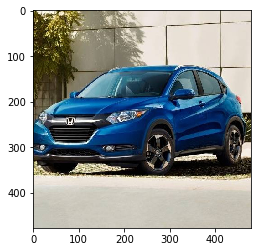

In [10]:
plt.figure()
plt.imshow(image)
plt.show()

In [11]:
image = image[:,:,1] # get green channel

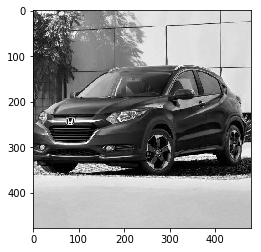

In [12]:
plt.figure()
plt.imshow(image,cmap='gray')
plt.show()

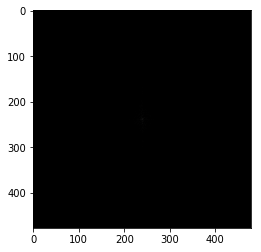

In [13]:
fft2 = np.fft.fftshift(np.fft.fft2(image))

plt.figure()
plt.imshow(np.abs(fft2),cmap='gray')
plt.show()

In [14]:
np.min(np.abs(fft2)), np.max(np.abs(fft2))

(0.06399988533009517, 118569.9215686274)

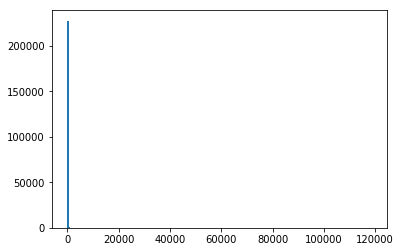

In [15]:
data = np.reshape(np.abs(fft2),[-1])

plt.figure()
plt.hist(data,bins=200)
plt.show()

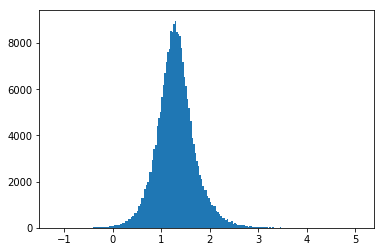

In [16]:
data = np.log10(data)

plt.figure()
plt.hist(data,bins=200)
plt.show()

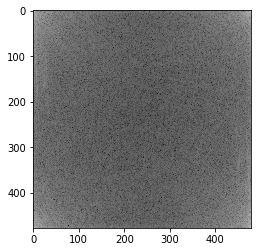

In [17]:
fft2 = np.fft.fft2(image)

plt.figure()
plt.imshow(np.log10(np.abs(fft2)),cmap='gray')
plt.show()

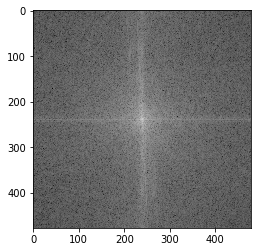

In [18]:
fft2 = np.fft.fftshift(np.fft.fft2(image))

plt.figure()
plt.imshow(np.log10(np.abs(fft2)),cmap='gray')
plt.show()

In [19]:
fft2.shape

(478, 478)

In [20]:
import numpy as np

def mask_radial(shape, r, inv=False, center=True):
    h, w = shape

    mask = np.zeros(shape)

    if center:
        cx = w//2
        cy = h//2
    else:
        cx = 0
        cy = 0 # h-1

    for x in range(w):
        rx = abs(cx - x)
        ry = int(np.sqrt(r ** 2 - rx ** 2)) if rx < r else 0
        y1 = max(0, cy - ry)
        y2 = min(h, cy + ry)
        mask[y1:y2,x] = 1.0
            
    if inv:
        mask = 1 - mask

    return mask


def mask_random(shape, p, seed=80208700):
    h, w = shape
    np.random.seed(seed)
    mask = (np.random.uniform(size=shape) > p).astype(int)
    return mask


def apply_mask(image, mask):
    orig_dt = None
    if np.amax(image) > 1.1:
        orig_dt = image.dtype
        image = image / 255.0
    fft2 = np.fft.fftshift(np.fft.fft2(image[:,:]))
    fft2 *= mask
    # fix imaginary values
    image2 = np.real(np.fft.ifft2(np.fft.ifftshift(fft2[:,:])))
    # fix range
    image2 = np.minimum(1.0,np.maximum(0.0,image2))
    # fix dtype
    if orig_dt is not None:
        image2 = (image2 * 255).astype(orig_dt)
    return image2

In [21]:
mask_radial((5,5),1.5)

array([[0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0.],
       [0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [22]:
max_h, max_w = fft2.shape
max_r = -int(-np.sqrt(max_h**2 + max_w ** 2))
max_r

675

In [23]:
dflt_area = 0.37 * max_h * max_w
dflt_r = np.sqrt(dflt_area / np.pi)
dflt_r

164.04153417010696

In [24]:
from ipywidgets import interact, FloatSlider

@interact(r=FloatSlider(min=0.5,max=max_r,step=0.1,value=dflt_r,continuous_update=False),inv=False,center=True)
def test_radial_noise(r,inv,center):
    mask = mask_radial(image.shape, r, inv, center)
    image2 = apply_mask(image, mask)

    fig = plt.figure(figsize=[15.5,5.5])
    ax1 = fig.add_subplot(121)
    ax1.imshow(mask,cmap='gray',vmin=0.0,vmax=1.0)
    ax2 = fig.add_subplot(122)
    ax2.imshow(image2,cmap='gray',vmin=0.0,vmax=1.0)

    plt.show()

interactive(children=(FloatSlider(value=164.04153417010696, continuous_update=False, description='r', max=675.…

In [25]:
mask_random((5,5),0.1)

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [26]:
from ipywidgets import interact, FloatSlider

@interact(p=FloatSlider(min=0.001,max=1.0,step=0.01,value=0.1,continuous_update=False))
def test_random_noise(p):
    mask = mask_random(image.shape, p)
    image2 = apply_mask(image, mask)

    fig = plt.figure(figsize=[15.5,5.5])
    ax1 = fig.add_subplot(121)
    ax1.imshow(mask,cmap='gray',vmin=0.0,vmax=1.0)
    ax2 = fig.add_subplot(122)
    ax2.imshow(image2,cmap='gray',vmin=0.0,vmax=1.0)

    plt.show()

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='p', max=1.0, min=0.001, ste…